In [1]:
pip install nltk

In [2]:
!pip install gensim

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, Bidirectional, Dropout

In [4]:
df = pd.read_csv('/content/28075442-stock-sentiment.csv')

In [5]:
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [7]:
df.isnull().sum()

,0
Text,0
Sentiment,0


<BarContainer object of 2 artists>

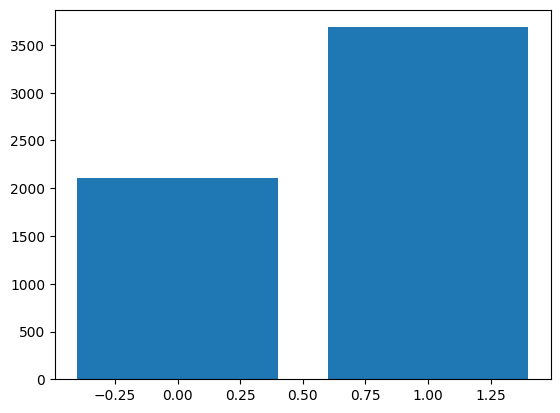

In [8]:
plt.bar(df['Sentiment'].value_counts().index, df['Sentiment'].value_counts())

## Performing data cleaning

In [9]:
 import string
 string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def remove_punc(message):
  Test_punc_removed = [char for char in message if char not in string.punctuation]
  Test_punc_removed_join = ''.join(Test_punc_removed)
  return Test_punc_removed_join

In [11]:
df['Text_without_punctuations'] = df['Text'].apply(remove_punc)

In [12]:
df.head()

,Text,Sentiment,Text_without_punctuations
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137


## Removing Stopwords

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use','will','app','co','day','user','stock','today','week','year'])

In [15]:
# remove stopwords and remove short words (less than 2 characters)
def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in stop_words and len(token) >=3:
      result.append(token)
  return  result

In [16]:
df['Text_without_punc_& stopwords'] = df['Text_without_punctuations'].apply(preprocess)

# PLOT WORDCLOUD

In [17]:
df['Text_without_punc_& stopwords_joined'] = df['Text_without_punc_& stopwords'].apply(lambda x : " ".join(x))

In [18]:
df.head()

,Text,Sentiment,Text_without_punctuations,Text_without_punc_& stopwords,Text_without_punc_& stopwords_joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz tra...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[aap, movie, return, feageed, indicator, trade...",aap movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop...",afraid short amzn looking like nearmonopoly eb...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[],


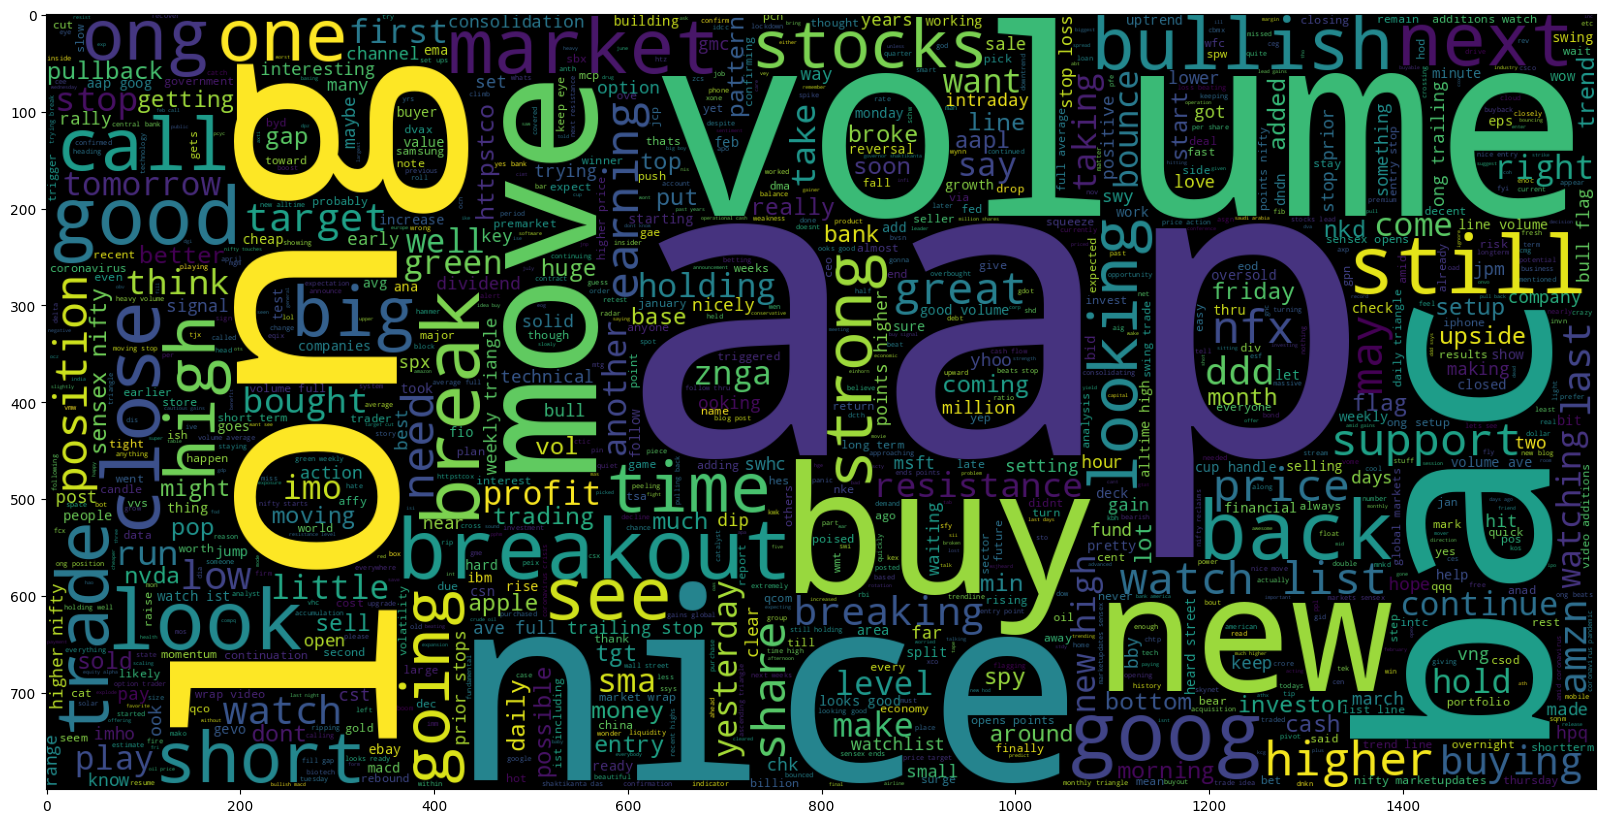

In [19]:
plt.figure(figsize=(20,30))
wc = WordCloud(max_words = 1000, width = 1600, height = 800).generate(" ".join(df[df['Sentiment'] ==1]['Text_without_punc_& stopwords_joined']))
plt.imshow(wc)

### Visualize the wordcloud for negative sentiment

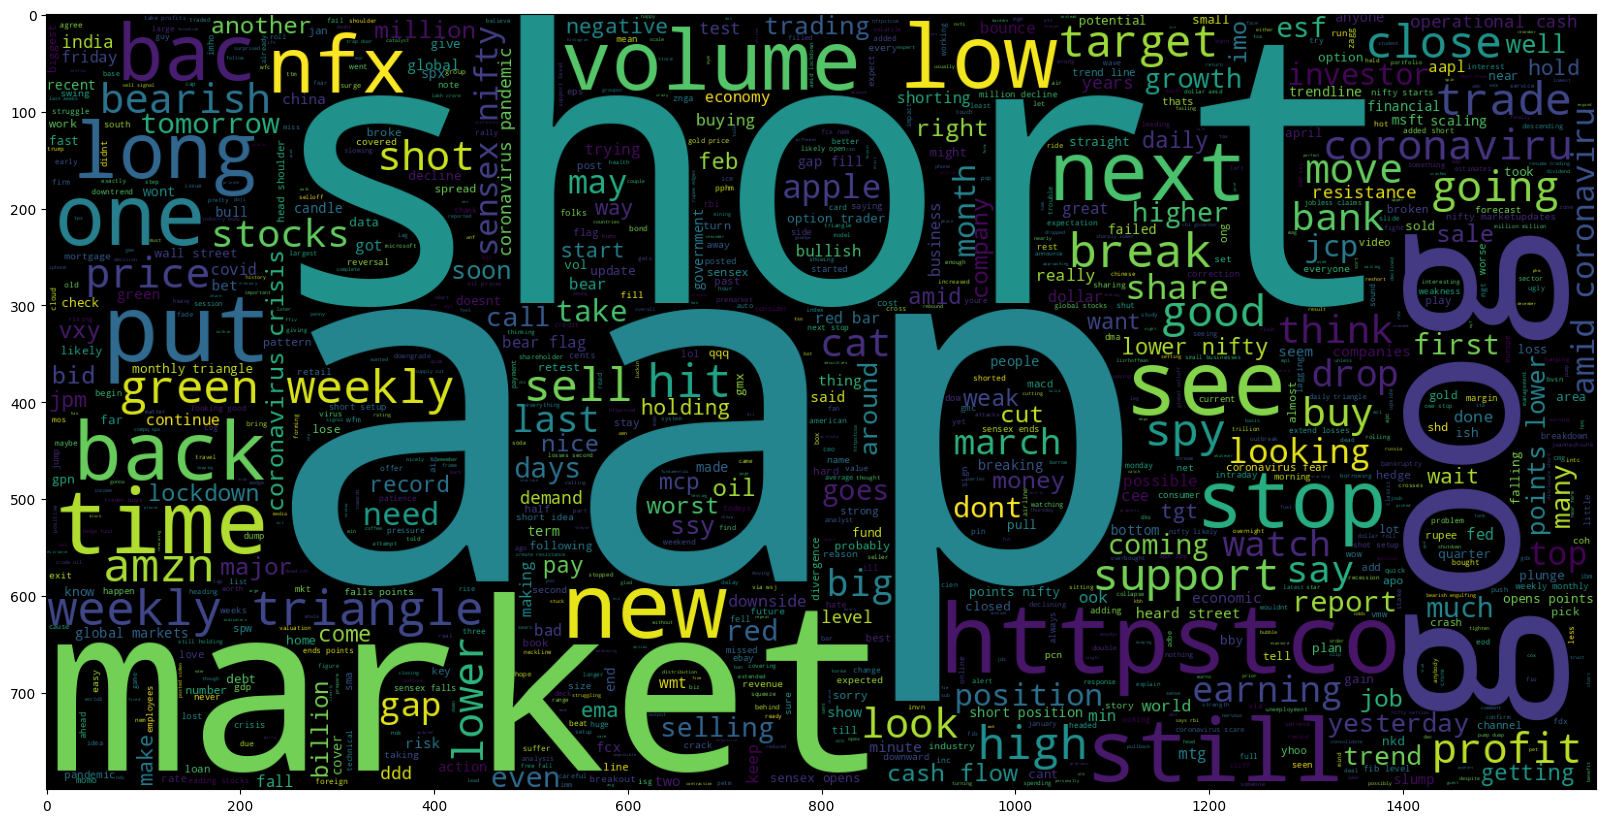

In [20]:
plt.figure(figsize=(20,30))
wc = WordCloud(max_words = 1000, width = 1600, height = 800).generate(" ".join(df[df['Sentiment'] ==0]['Text_without_punc_& stopwords_joined']))
plt.imshow(wc)

##Tokenization

In [21]:
nltk.download('punkt')
nltk.word_tokenize(df['Text_without_punc_& stopwords_joined'][0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts']

In [22]:
## Obtaining the maximum length of data in the document
# This will be later used when word embeddings are generated

In [23]:
maxlen = -1

for doc in df['Text_without_punc_& stopwords_joined']:
  tokens = nltk.word_tokenize(doc)
  if(maxlen < len(tokens)):
    maxlen = len(tokens)

print("Max number of words in any document is :", maxlen)

Max number of words in any document is : 20


In [24]:
tweets_len = [ len(nltk.word_tokenize(x)) for x in df['Text_without_punc_& stopwords_joined']]
tweets_len

[14,
 7,
 7,
 1,
 0,
 1,
 9,
 13,
 8,
 5,
 10,
 18,
 9,
 8,
 11,
 5,
 12,
 10,
 12,
 4,
 6,
 6,
 2,
 5,
 3,
 10,
 3,
 3,
 9,
 6,
 9,
 10,
 8,
 3,
 10,
 11,
 4,
 9,
 12,
 11,
 10,
 7,
 10,
 8,
 4,
 10,
 8,
 7,
 7,
 9,
 10,
 10,
 8,
 2,
 14,
 13,
 9,
 8,
 1,
 14,
 8,
 12,
 5,
 13,
 6,
 6,
 7,
 6,
 6,
 10,
 9,
 4,
 11,
 13,
 16,
 6,
 9,
 6,
 2,
 11,
 5,
 4,
 10,
 11,
 16,
 4,
 9,
 5,
 6,
 3,
 1,
 5,
 9,
 4,
 7,
 6,
 7,
 10,
 1,
 3,
 9,
 4,
 16,
 8,
 10,
 11,
 18,
 6,
 7,
 13,
 12,
 9,
 3,
 4,
 10,
 11,
 9,
 6,
 8,
 5,
 5,
 8,
 9,
 15,
 3,
 5,
 9,
 18,
 13,
 11,
 3,
 1,
 1,
 2,
 7,
 13,
 12,
 8,
 8,
 10,
 9,
 10,
 15,
 8,
 9,
 9,
 12,
 10,
 6,
 10,
 13,
 4,
 12,
 10,
 16,
 14,
 9,
 12,
 5,
 5,
 3,
 8,
 2,
 4,
 10,
 6,
 6,
 11,
 6,
 16,
 9,
 6,
 5,
 10,
 9,
 11,
 8,
 2,
 10,
 9,
 10,
 12,
 7,
 10,
 7,
 3,
 6,
 5,
 9,
 9,
 4,
 6,
 5,
 4,
 4,
 9,
 10,
 8,
 8,
 13,
 9,
 7,
 10,
 12,
 8,
 6,
 5,
 3,
 10,
 11,
 6,
 9,
 10,
 13,
 10,
 7,
 12,
 7,
 11,
 10,
 4,
 4,
 3,
 10,
 2,
 9,
 10,
 15,
 12,


In [25]:
# Plotting the distribution for the number of words in a text
fig = px.histogram(x = tweets_len, nbins = 50)
fig.show()

In [26]:
df.columns

Index(['Text', 'Sentiment', 'Text_without_punctuations',
       'Text_without_punc_& stopwords',
       'Text_without_punc_& stopwords_joined'],
      dtype='object')

In [27]:
# obtain the total words present in the dataset
list_of_words = []

for i in df['Text_without_punc_& stopwords']:
  for j in i:
    list_of_words.append(j)

In [28]:
list_of_words

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts',
 'aap',
 'movie',
 'return',
 'feageed',
 'indicator',
 'trades',
 'awesome',
 'afraid',
 'short',
 'amzn',
 'looking',
 'like',
 'nearmonopoly',
 'ebooks',
 'mnta',
 'pgnx',
 'aap',
 'current',
 'downtrend',
 'break',
 'otherwise',
 'shortterm',
 'correction',
 'medterm',
 'downtrend',
 'mondays',
 'relative',
 'weakness',
 'nyx',
 'win',
 'tie',
 'tap',
 'ice',
 'int',
 'bmc',
 'aon',
 'chk',
 'biib',
 'goog',
 'ower',
 'trend',
 'line',
 'channel',
 'test',
 'volume',
 'support',
 'aap',
 'watch',
 'tomorrow',
 'ong',
 'entry',
 'assuming',
 'fcx',
 'opens',
 'tomorrow',
 'trigger',
 'buy',
 'still',
 'much',
 'like',
 'setup',
 'really',
 'worries',
 'everyone',
 'expects',
 'market',
 'rally',
 'nowusually',
 'exact',
 'opposite',
 'happens',
 'every',
 'time',
 'shall',
 'see',
 'soon',
 'bac',
 'spx',
 'jpm',
 'aap',
 'gamcos',
 'arry',
 'haverty'

In [29]:
# total number of unique words
list(set(list_of_words))

['edmc',
 'breakuplooking',
 'hurdled',
 'travel',
 'mover',
 'keo',
 'rosa',
 'governmentled',
 'roughly',
 'usertools',
 'group',
 'oveeacting',
 'financialâ',
 'hit',
 'saturated',
 'httâ',
 'wendys',
 'wedemember',
 'httpstcogachu',
 'res',
 'barrel',
 'pullbackconsol',
 'resulting',
 'itg',
 'wants',
 'itt',
 'companys',
 'magenta',
 'sjzu',
 'followthrough',
 'hpwxg',
 'fundraising',
 'flight',
 'squeezie',
 'missyaubaby',
 'trade',
 'fired',
 'horrible',
 'cautiously',
 'onxx',
 'packâ',
 'crg',
 'nobiano',
 'almost',
 'extent',
 'gman',
 'epr',
 'dilutive',
 'bird',
 'sizable',
 'qqqaystv',
 'onbullish',
 'appreciated',
 'seeking',
 'tricky',
 'tbkkonte',
 'skynet',
 'audio',
 'competitive',
 'ntap',
 'skybridge',
 'erics',
 'column',
 'debts',
 'decoupling',
 'salary',
 'tune',
 'upgrade',
 'caseno',
 'gnw',
 'dom',
 'disapointment',
 'weather',
 'hes',
 'mims',
 'shorters',
 'esiient',
 'rode',
 'misplacâ',
 'tcpdating',
 'overextended',
 'acx',
 'seeturn',
 'selfemployed',
 

In [30]:
total_words = len(list(set(list_of_words)))
total_words

9268

In [31]:
# splitting the data into train and test
X = df['Text_without_punc_& stopwords']
y = df['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=42)

In [32]:
X_train.shape

(5211,)

In [33]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

#Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)

In [34]:
print("the encoding for the ducument\n",X_train[1:2], 'is', train_sequences[1])

the encoding for the ducument
 1073    [bzh, beazer, homes, option, traders, getting,...
Name: Text_without_punc_& stopwords, dtype: object is [3618, 3619, 982, 149, 417, 107, 41, 56, 69, 76]


In [35]:
# Add padding to training and testing
padding_train = pad_sequences(train_sequences, maxlen=29)
padding_test = pad_sequences(test_sequences, maxlen=29)

In [36]:
for i, doc in enumerate(padding_train[:3]):
  print('The padded encoding for the document:', i+1, 'is',doc)

The padded encoding for the document: 1 is [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 439 238   1  14]
The padded encoding for the document: 2 is [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 3618 3619  982  149  417  107   41   56   69
   76]
The padded encoding for the document: 3 is [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  66 189  16 290]


In [38]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train,2)
y_test_cat = to_categorical(y_test,2)

In [44]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Define the total number of words in your vocabulary and the maximum sequence length
max_len = 100  # maximum length of the input sequences

model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=512, input_length=max_len))
model.add(LSTM(256))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

# Explicitly building the model by specifying the input shape
model.build(input_shape=(None, max_len))  # 'None' can be used for unspecified batch size

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 512)            │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,940,610 (22.66 MB)

 Trainable params: 5,940,610 (22.66 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# train the model
model.fit(padding_train, y_train_cat, batch_size=32, validation_split=0.2, epochs=20)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - accuracy: 0.6606 - loss: 0.6216 - val_accuracy: 0.7756 - val_loss: 0.5035
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 48s 328ms/step - accuracy: 0.8807 - loss: 0.2953 - val_accuracy: 0.7306 - val_loss: 0.5659
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 363ms/step - accuracy: 0.9549 - loss: 0.1258 - val_accuracy: 0.7354 - val_loss: 0.8559
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 385ms/step - accuracy: 0.9803 - loss: 0.0518 - val_accuracy: 0.7392 - val_loss: 1.2264
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 369ms/step - accuracy: 0.9871 - loss: 0.0303 - val_accuracy: 0.7315 - val_loss: 1.4154
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 253ms/step - accuracy: 0.9881 - loss: 0.0285 - val_accuracy: 0.7248 - val_loss: 1.4587
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 265ms/step - accuracy: 0.9916 - loss: 0.0250 - val_accuracy: 0.7335 - val_loss: 1.4163
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.9958 - loss: 0

In [47]:
# make predictions
pred = model.predict(padding_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step


In [48]:
# make predictions
# argmax finds the argument that gives the maximum value and used to find the class with the highest probability(predictions).

prediction = []
for i in pred:
  prediction.append(np.argmax(i))


In [49]:
prediction

[1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,


In [50]:
# list containing original values
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [51]:
original

[0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,


In [54]:
from sklearn.metrics import accuracy_score

# Assuming 'original' and 'prediction' are your actual variables holding the true labels and predicted labels
accuracy = accuracy_score(original, prediction)
print(accuracy)

0.7517241379310344


<Axes: >

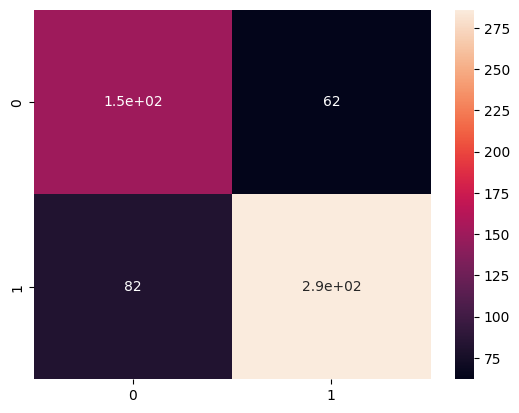

In [55]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm,annot=True)